In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_train.shape

(42000, 785)

In [5]:
X = df_train.drop(['label'], axis = 1)
y = df_train['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

test_valid_size = 0.33

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=test_valid_size, random_state=42)

X_train = X_train.values.reshape(-1, 28, 28, 1)
X_valid = X_valid.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [13]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(10, activation = 'softmax'))
model.compile(loss ='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


model_history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_valid, y_valid))

Epoch 1/20
 70/460 [===>..........................] - ETA: 1:00 - loss: 0.6912 - accuracy: 0.8170

KeyboardInterrupt: 

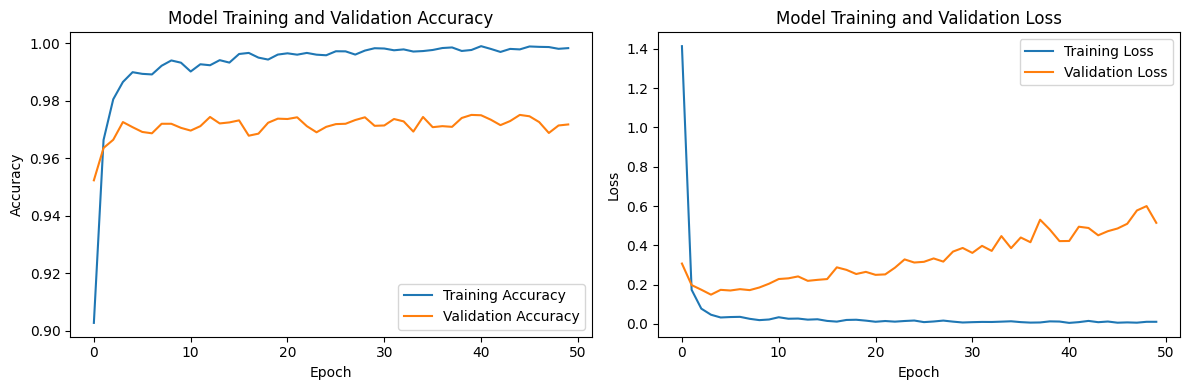

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()